In [1]:
%run ./tools.ipynb

In [4]:
# inversion configurations
year        = 2018

nx          = 22   # number of tagged tracers, same as number of masks
mask_type   = 'giorgi' # world mask, splits global into 22 regions
mode        = 'N' # OCO-2 Nadir only
mod_err     = 0.5 #1.5 # model/transport error, unit: ppm
prior_err   = 2. #0.5 # intial prior error, unitless, multiply biospheric flux for actual prior error

# total CO2 simulation directory
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'


In [5]:
%run bio_flux_functions.ipynb

fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2020-04/NEE.Liang.2016.nc'
monthly_bio_flux = regional_monthly_bio(fname)


finished creating masks for giorgi
Biospheric annual flux (PgC/year):  -0.46886576590142404


In [6]:
update_array_1month = np.zeros(12)
update_array_2month = np.zeros(12)
update_array_3month = np.zeros(12)
update_matrix1 = np.zeros((12,nx)) # store adjustments for each region each month
update_matrix2 = np.zeros((12,nx)) # store adjustments for each region each month
update_matrix3 = np.zeros((12,nx)) # store adjustments for each region each month


In [8]:

lag_window  = 3    # months

# prior error
del_X_f = np.diag(np.repeat(prior_err,nx))
del_X_f[7,7] = 0.1  # Alaska 
del_X_f[8,8] = 0.1  # Greenland
del_X_f[21,21] = 0.1
#print('initial: ', np.diag(del_X_f))

del_X_lag = np.zeros((nx*lag_window,nx*lag_window))
for i in range(lag_window): del_X_lag[i*nx:(i+1)*nx,i*nx:(i+1)*nx] = del_X_f #[nx*nlag, nx*nlag], diag,
print('actual:', np.diag(del_X_lag))
del_X_updated = del_X_lag


actual: [2.  2.  2.  2.  2.  2.  2.  0.1 0.1 2.  2.  2.  2.  2.  2.  2.  2.  2.
 2.  2.  2.  0.1 2.  2.  2.  2.  2.  2.  2.  0.1 0.1 2.  2.  2.  2.  2.
 2.  2.  2.  2.  2.  2.  2.  0.1 2.  2.  2.  2.  2.  2.  2.  0.1 0.1 2.
 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.1]


In [9]:
update_array_3month = np.zeros(12)
update_matrix3 = np.zeros((12,nx))

Jan adjustment: 0.97
Feb adjustment: 0.09
Mar adjustment: -0.02
[ 0.97192314  0.09023385 -0.01513745  0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
y diff before: -1.00
y diff after: -0.11
R1 is: 0.89  RMSE1 is:  1.61
R2 is: 0.92  RMSE2 is:  1.04
Feb adjustment: 1.26
Mar adjustment: 0.23
Apr adjustment: 0.25
[0.97192314 1.35315444 0.21354674 0.25145231 0.         0.
 0.         0.         0.         0.         0.         0.        ]
y diff before: -1.65
y diff after: -0.36
R1 is: 0.88  RMSE1 is:  2.18
R2 is: 0.91  RMSE2 is:  1.21
Mar adjustment: 0.60
Apr adjustment: 0.55
May adjustment: 0.43
[0.97192314 1.35315444 0.80894114 0.80512048 0.43483581 0.
 0.         0.         0.         0.         0.         0.        ]
y diff before: -1.77
y diff after: -0.45
R1 is: 0.88  RMSE1 is:  2.21
R2 is: 0.9  RMSE2 is:  1.22
Apr adjustment: 0.39
May adjustment: 0.24
Jun adjustment: 0.03
[0.97192314 1.35315444 0.80894114 1.19353422 0.67924989 0.

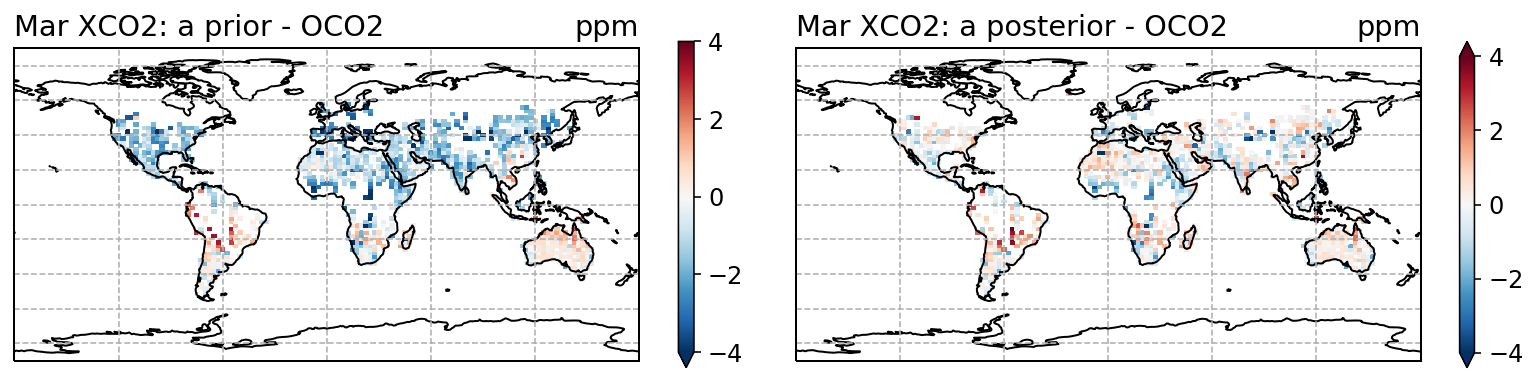

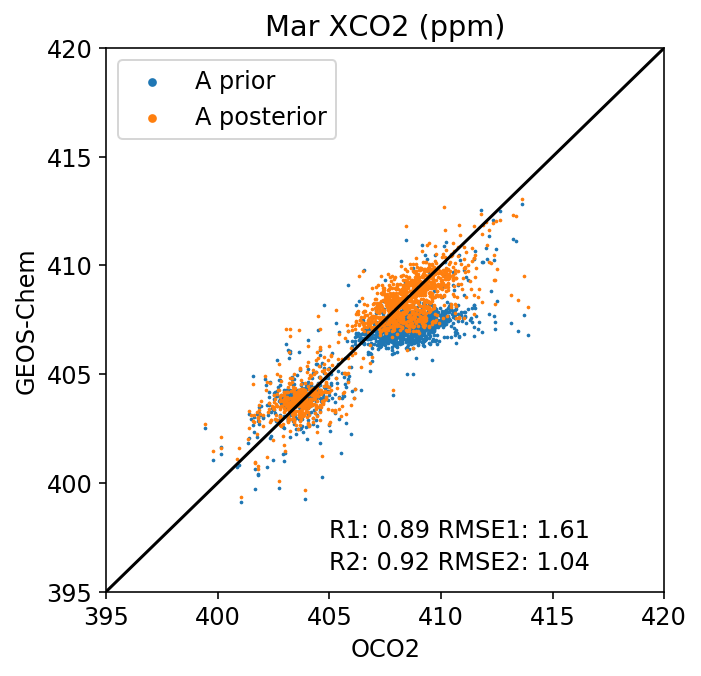

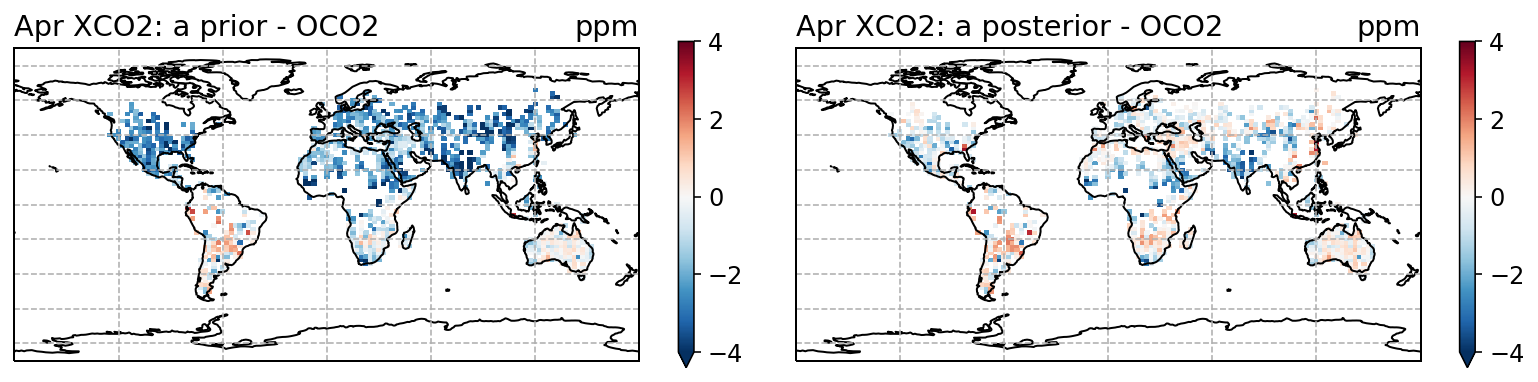

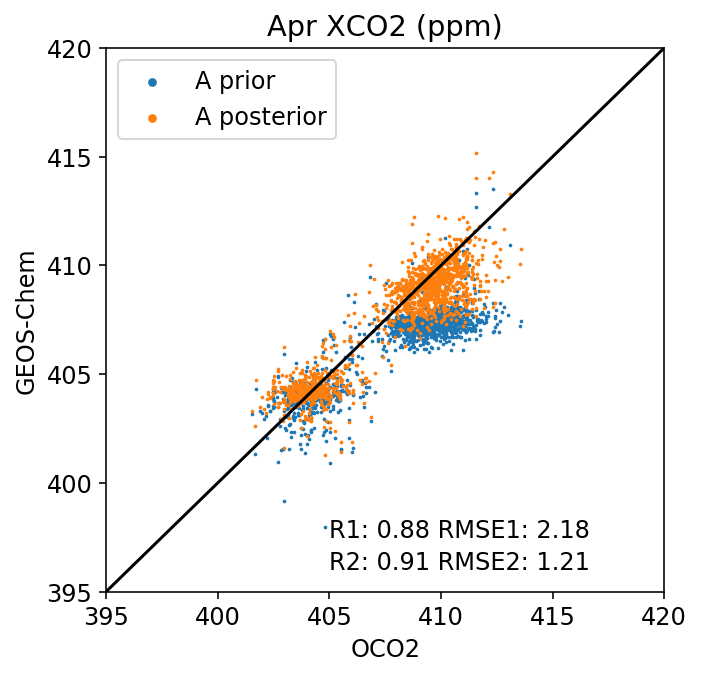

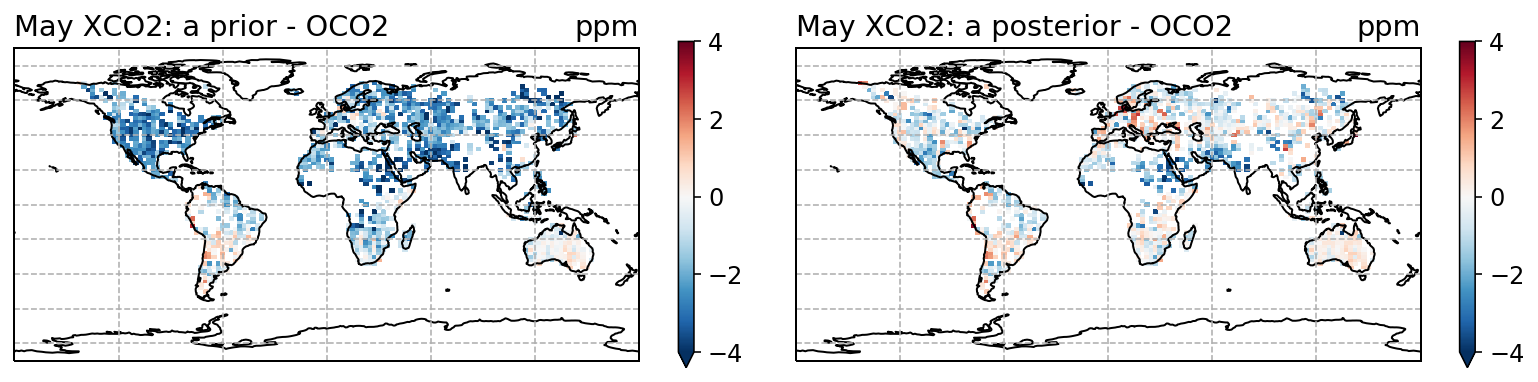

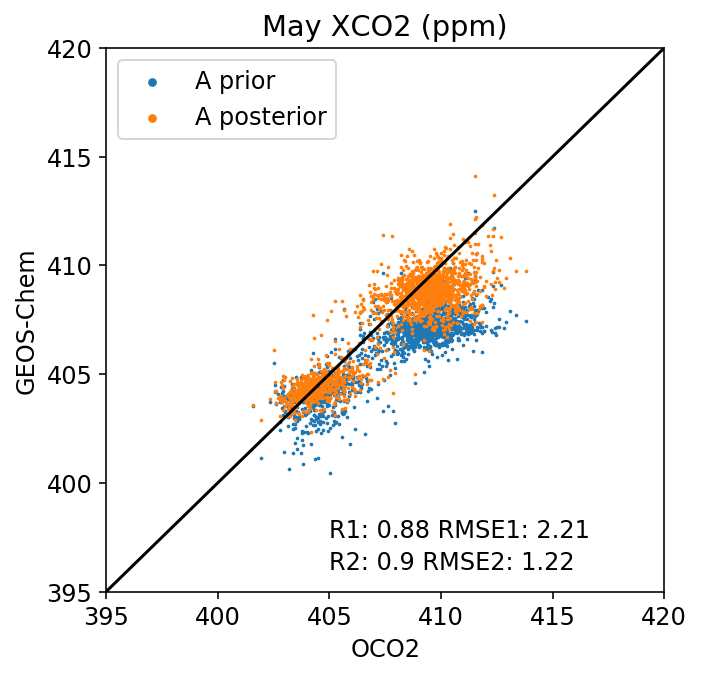

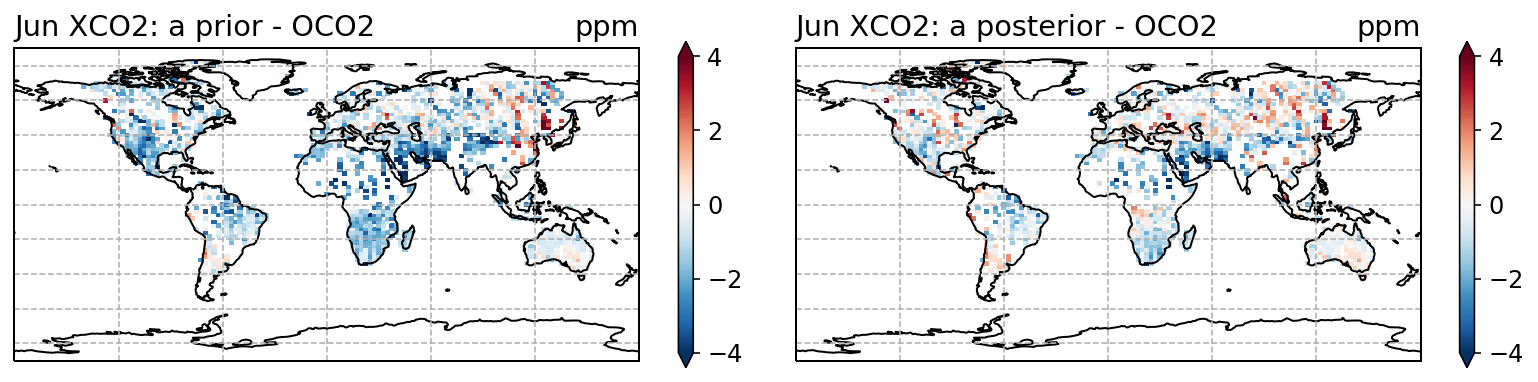

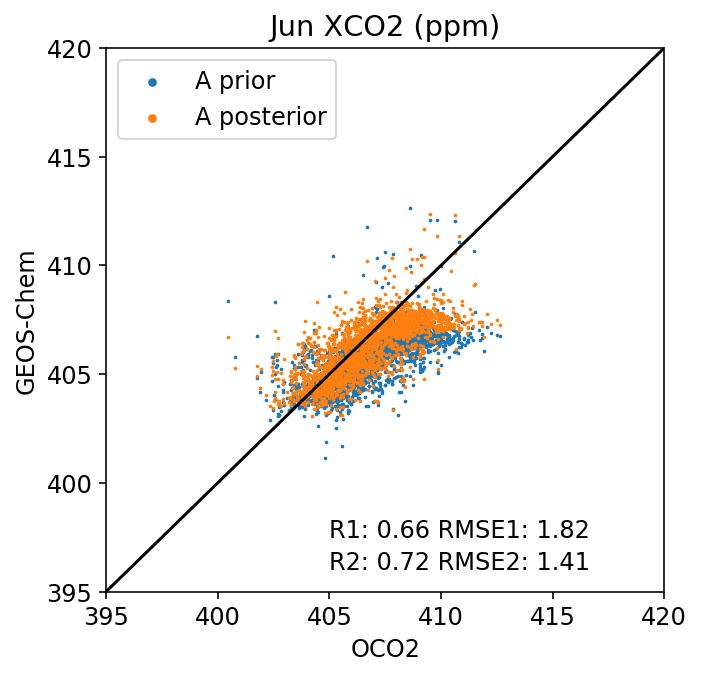

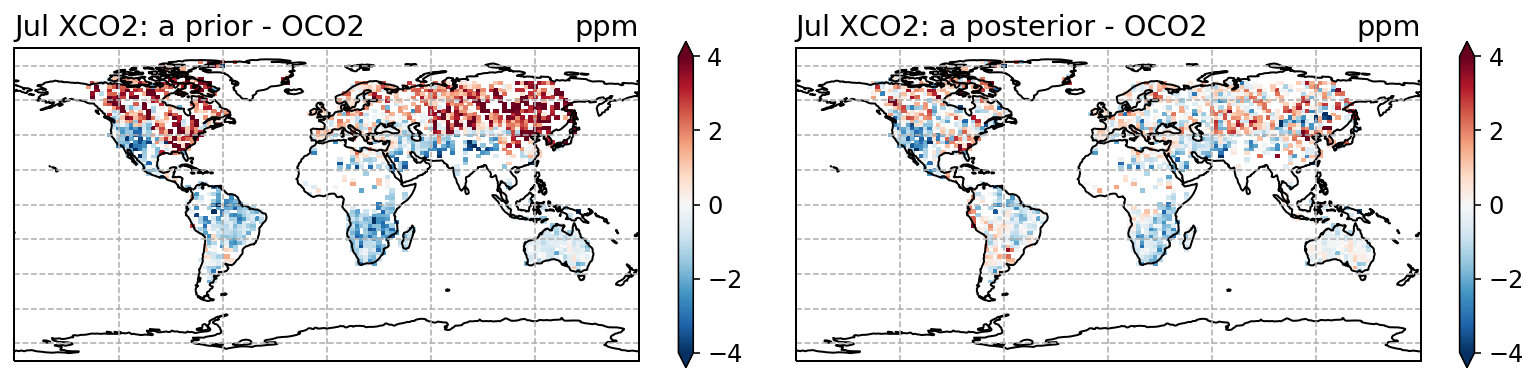

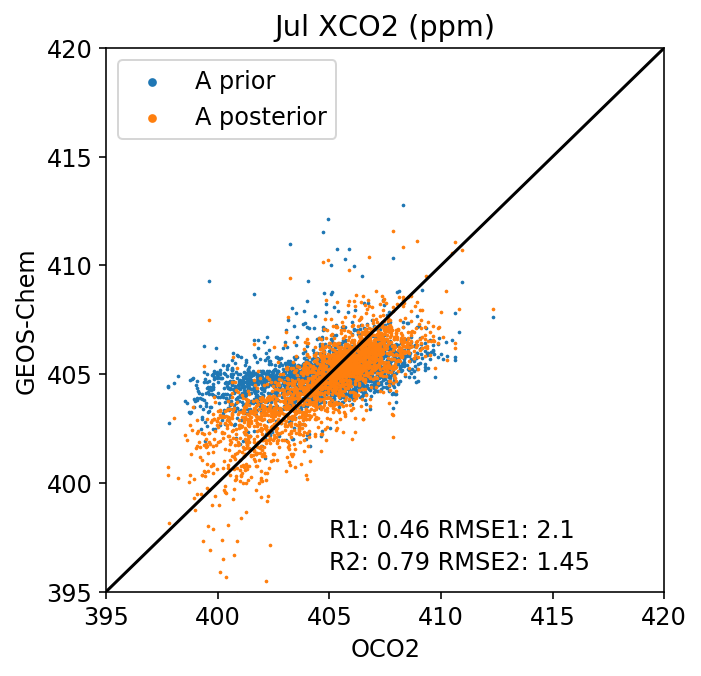

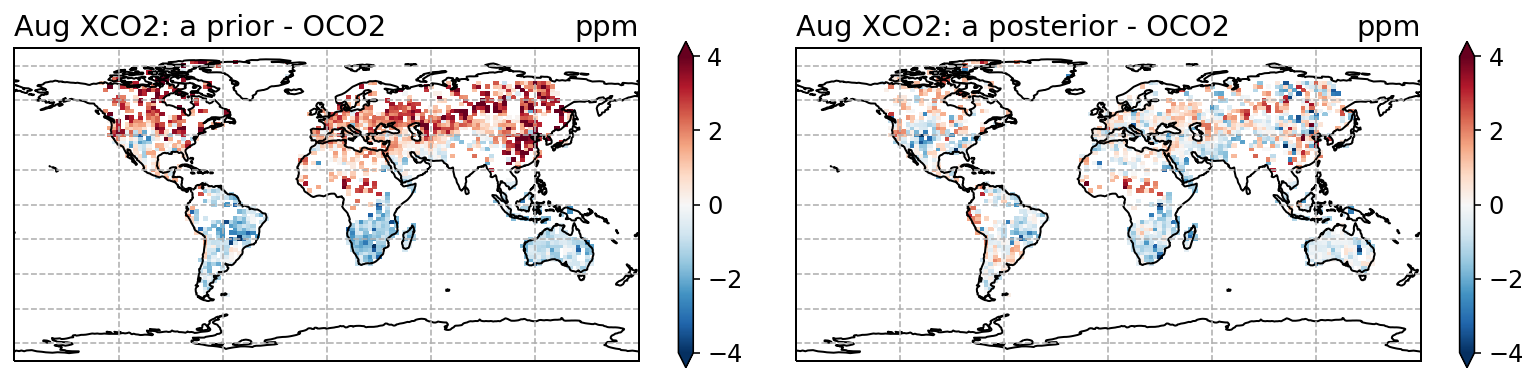

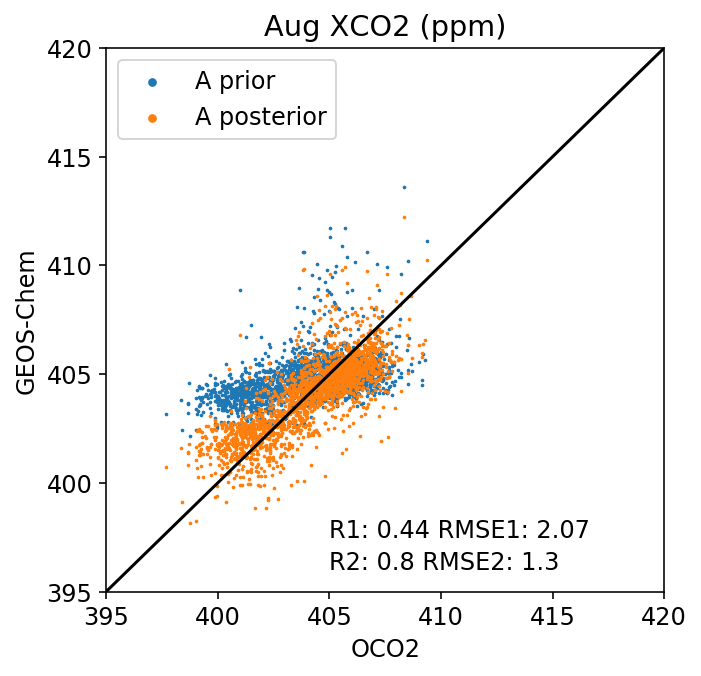

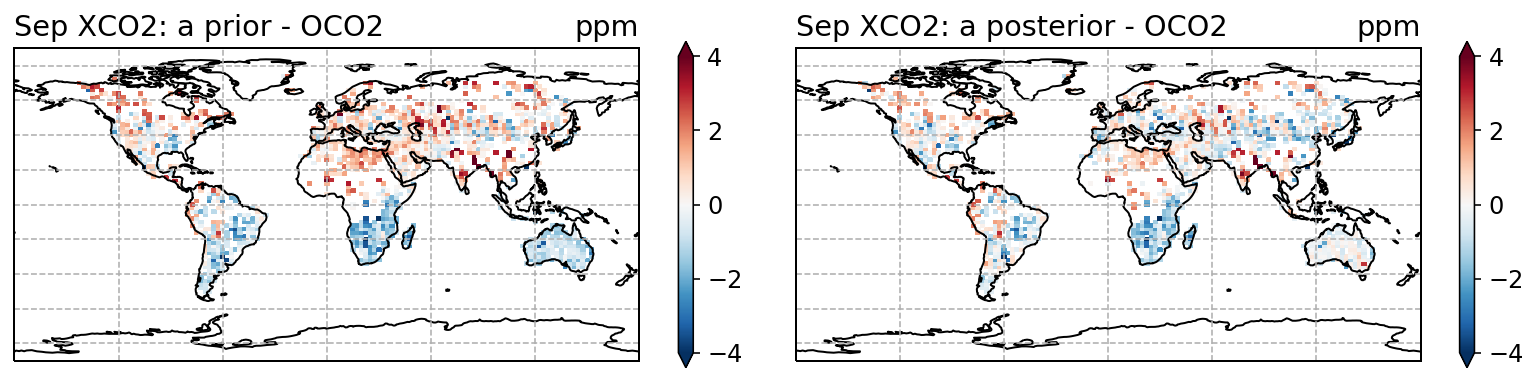

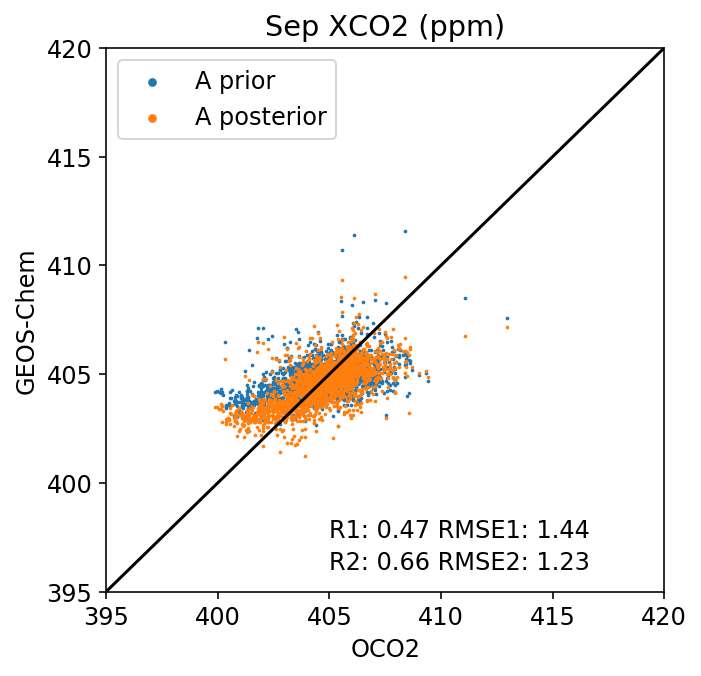

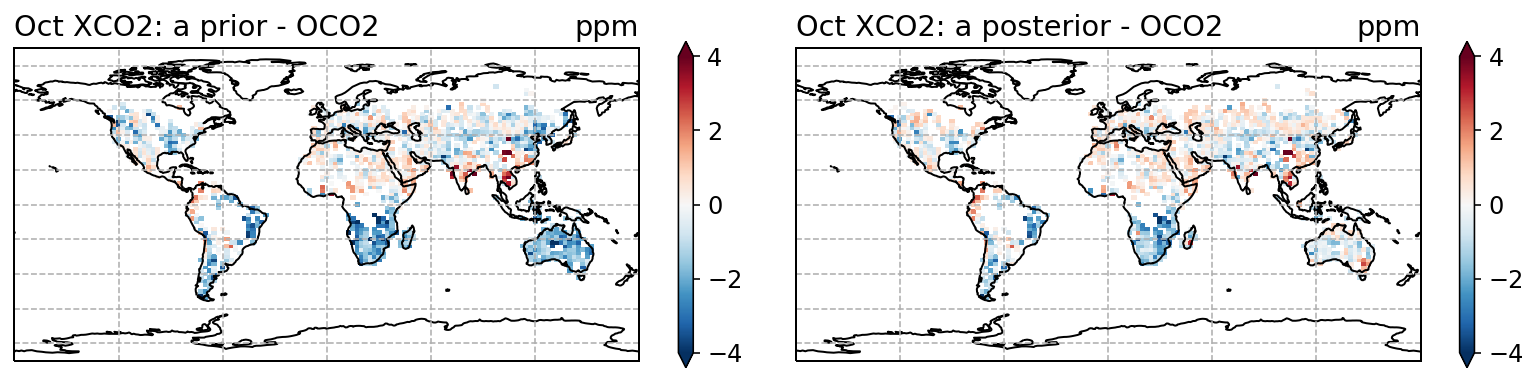

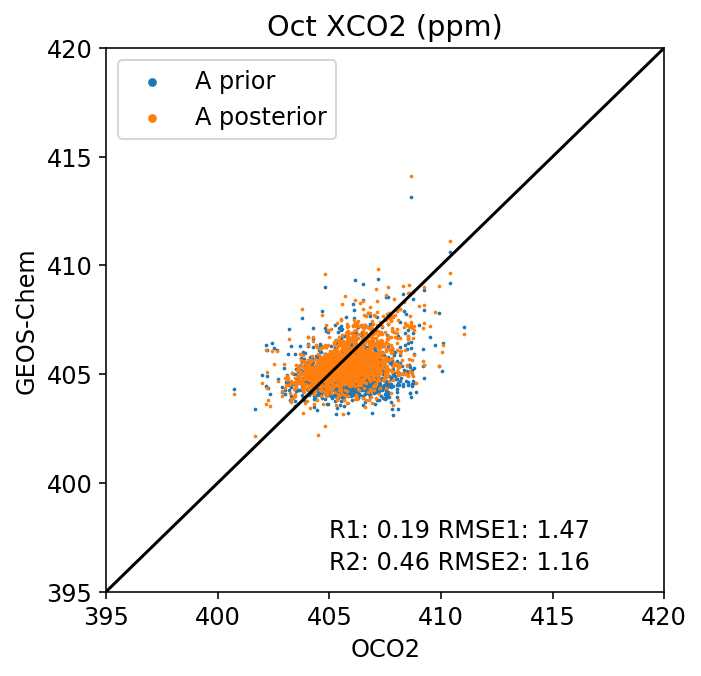

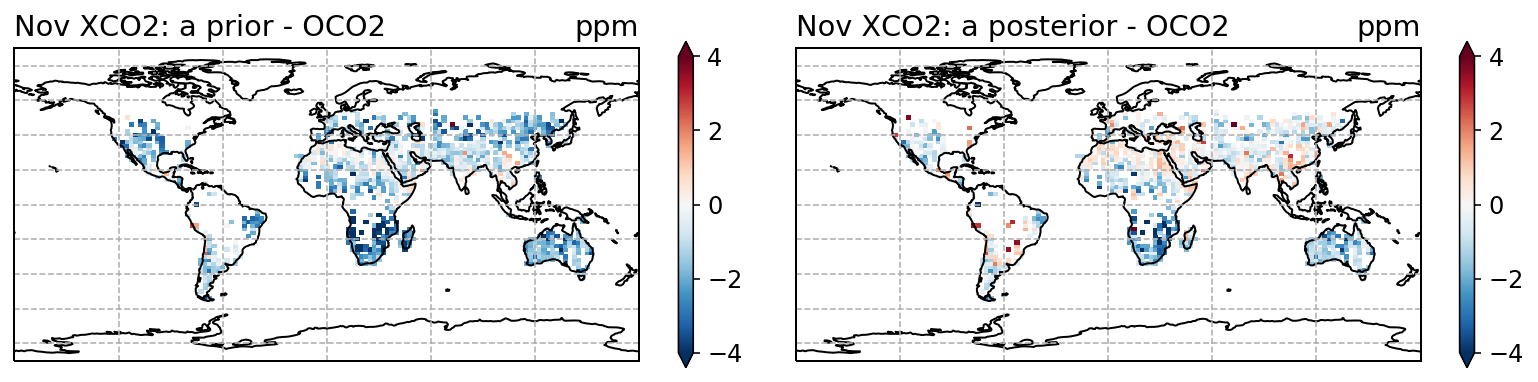

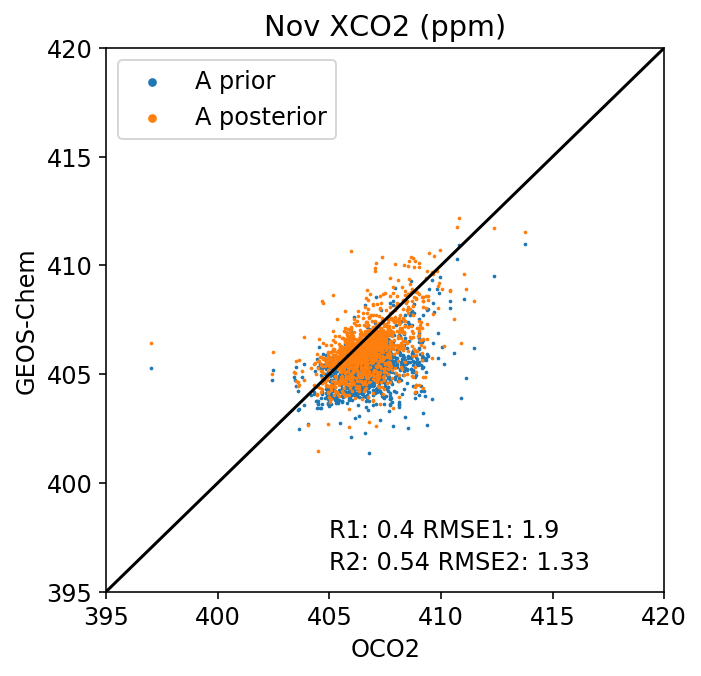

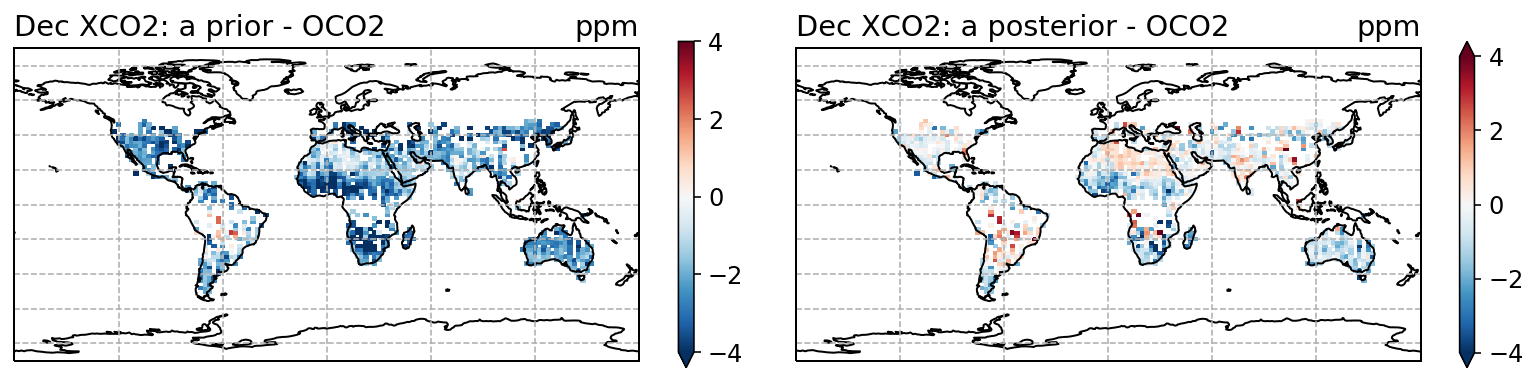

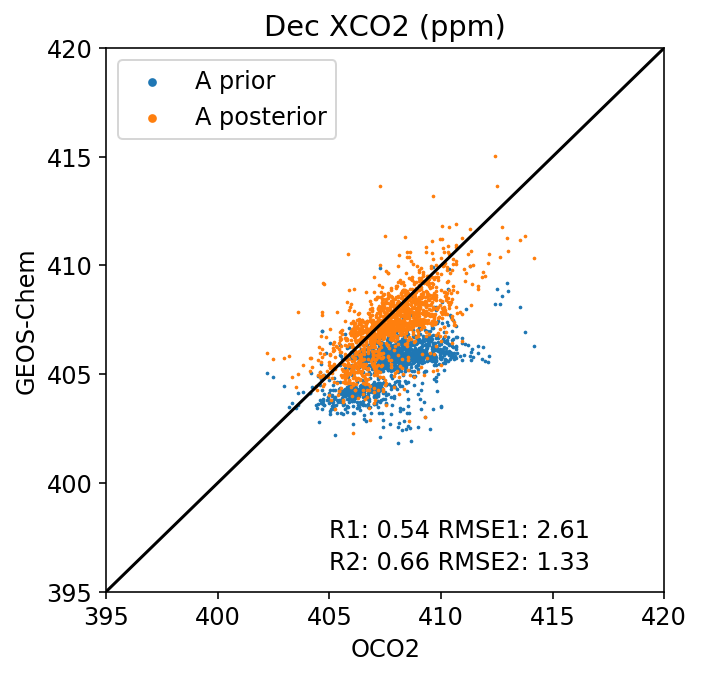

In [10]:
# start of inversion calculation:
for assim_month in range(3,13):
    # 1, read in from full CO2 simulations
    name_month = short_name_of_month(assim_month) # Jan, Feb, Mar, ...
    xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    mod_dir = top_dir + 'CO2-' + str(year) + '/nd51/'
    ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']  # XCO2 from OCO-2
    xco2_model = ds_xco2['xco2_model'] # XCO2 from model
    xco2_error = ds_xco2['xco2_error'] # measurement error from OCO-2
    diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
    # reduce the size of above arrays and matrices, from ~400k to <3k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    nobs = len(ind) # number of obs in this month
    # get slices of arrays
    diff_slice = diff[ind].values            # [nobs], 1-3k per month
    lat_slice = ds_xco2.lat[ind]
    lon_slice = ds_xco2.lon[ind]
    xco2_mod_slice = xco2_model[ind]
    xco2_oco_slice = xco2_oco2[ind]
    xco2_error_slice = xco2_error[ind].values 
    # observation error
    obs_error = np.zeros((nobs,nobs))  # [nobs,nobs], diagonally store obs error
    for idiag in range(nobs):
        obs_error[idiag, idiag] = (xco2_error_slice[idiag])**2 + mod_err**2
        # measurment error from oco2
        # model error and representation error = 2.5 for land

    # delta y0
    del_Y = np.empty((nobs,nx*lag_window))   # [nobs, nx*lag_window]
    del_Y[:] = np.nan

    # 2, read in tag runs
    for itmp in range(lag_window):
        ilag_month = assim_month - lag_window + itmp + 1
        ens_dir = top_dir + 'CO2-casa-2018-' + month_string(ilag_month) + '/nd51/'
        delta_y0_file = 'delta_y0_model_N_' + str(assim_month) + '.nc'
        # open datasets
        ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
        varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
        needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
        # read variables
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag+nx*itmp] = ds_delta_y0[ivar][ind].values # column order: assim_month - 2, assim_month - 1, assim_month

    del_Y0 = del_Y
    del_X_lag = del_X_updated # update
    del_Y = np.dot(del_Y, del_X_lag)
    
    # calculation of posterior
    del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [nx*lag_window,nobs]
    first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
    second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs], dominated by second term, issue???
    third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
    k_e        = np.matmul(del_X_lag,third)     # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [nx*lag_window,nobs]
    adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [nx*lag_window]

    update = adjust * monthly_bio_flux[assim_month-lag_window:assim_month].flatten()
    # monthly updates
    update_matrix3[assim_month-lag_window:assim_month] += update.reshape(lag_window,nx)
    for i in range(lag_window):
        print(short_name_of_month(assim_month - lag_window + i + 1), 'adjustment: {:.2f}'.format(sum(update[i*nx:(i+1)*nx])))
        update_array_3month[assim_month - lag_window + i] +=  sum(update[i*nx:(i+1)*nx])
    print(update_array_3month)
    
    # update Y matrix
    diff_new = diff_slice - np.dot(del_Y0,adjust) # [nobs], ppm
    plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, assim_month)

    # transformation matrix to update prior
    fourth = np.identity(nx*lag_window) - np.matmul(third, del_Y)
    transform_mat = sp.sqrtm(fourth)

    del_X_lag = np.matmul(del_X_lag, transform_mat)

    # update del_X_lag and use it in next assimilation
    del_X_updated = np.zeros((nx*lag_window,nx*lag_window))
    del_X_updated[:(lag_window-1)*nx, :(lag_window-1)*nx] = del_X_lag[nx:,nx:]
    del_X_updated[(lag_window-1)*nx:, (lag_window-1)*nx:] = del_X_f

    #print(np.diag(del_X_updated))

In [53]:
# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
dr_monthly = ds_monthly['ff'] # just for making a mask

# create masks for this resolution
dr = dr_monthly[0,:,:]
# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target

# monthly net fluxes for 22 tagged regions
monthly_net_flux_casa = np.zeros((12,nm_masks+1))
dr_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['casa_bio']

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        monthly_net_flux_casa[i,j] = tmp.sum().values*1e-12*12/44
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12*12/44
    masked_sum = sum(monthly_net_flux_casa[i,:])
    monthly_net_flux_casa[i,-1] = sum_tmp - masked_sum

net_flux_2018 = np.sum(monthly_net_flux_casa, axis = 1) # global net flux
print('My annual total net flux w/ CASA (PgC/year): ', np.sum(net_flux_2018))


finished creating masks for giorgi
My annual total net flux w/ CASA (PgC/year):  3.889662349684364


In [54]:
# Liang's posterior
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/liang/oco2_v9_2014_2018_monthly_flux.nc'
ds_liang = xr.open_dataset(fname)
varname  = 'flux'           # unit: kgC/m2/d
dr_2018  = ds_liang[varname][-12:,:,:]/(24*3600) # 2018 monthly, unit convert to kgC/m2/s
dr_2018_monthly_total = unit_convert_monthly(dr_2018, 2018, 4., 5.)
print('Liang 2018 global net flux (PgC/year):', dr_2018_monthly_total.sum().values*1e-12)

# create masks for this resolution
dr = dr_2018_monthly_total[0,:,:]

# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target
    
dr_monthly = dr_2018_monthly_total
# monthly net fluxes for 22 tagged regions
net_monthly_liang = np.zeros((12,nm_masks+1))

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        net_monthly_liang[i,j] = tmp.sum().values*1e-12
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12
    masked_sum = sum(net_monthly_liang[i,:])
    net_monthly_liang[i,-1] = sum_tmp - masked_sum

print('check after applying masks: global net flux:', np.sum(net_monthly_liang))

net_flux_liang = np.sum(net_monthly_liang, axis = 1) # global net flux


Liang 2018 global net flux (PgC/year): 4.44784598339217
finished creating masks for giorgi
check after applying masks: global net flux: 4.447845983392172


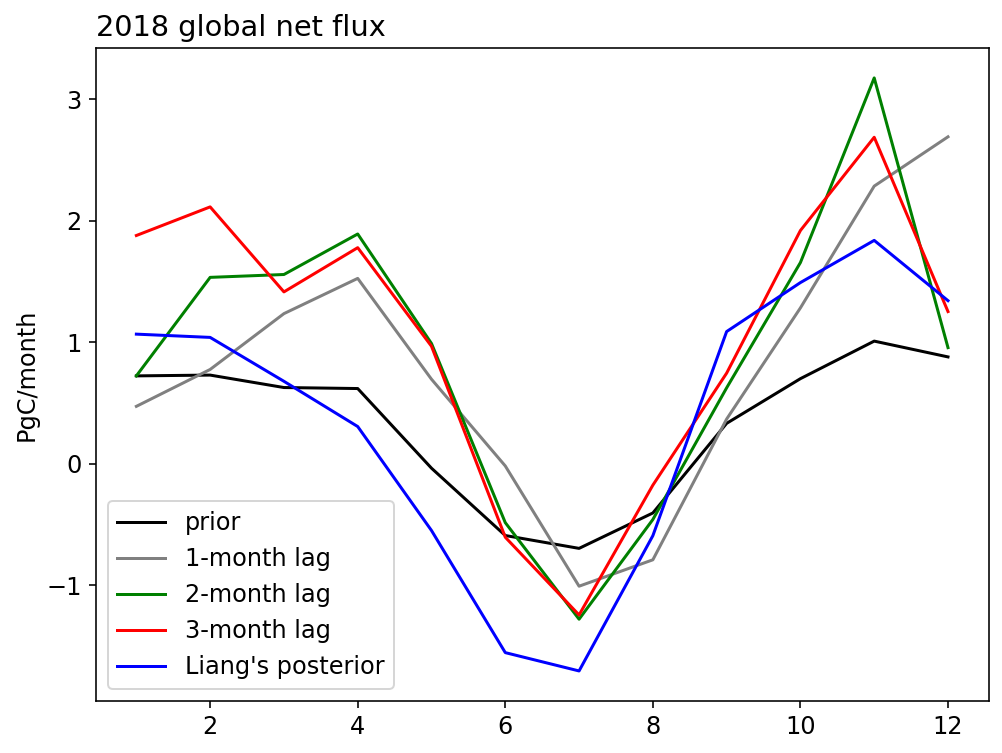

In [89]:
fig, ax = plt.subplots(figsize=[8, 6])
# prior
ax.plot(range(1,13), net_flux_2018, label = 'prior', color = 'black')
ax.plot(range(1,13), net_flux_2018 + update_array_1month, label = '1-month lag', color = 'grey')
ax.plot(range(1,13), net_flux_2018 + update_array_2month, label = '2-month lag', color = 'green')
ax.plot(range(1,13), net_flux_2018 + update_array_3month, label = '3-month lag', color = 'red')
ax.plot(range(1,13), net_flux_liang, label = "Liang's posterior", color = 'blue')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

fig.savefig(mod_dir + 'inversion_global_lags.png', dpi = 300)


In [107]:
posterior = np.zeros((12,nx)) # regional, monthly mean, posterior
for i in range(nx): posterior[:,i] = monthly_net_flux_casa[:,i] + adjust_matrix[:,i]


fig, axs = plt.subplots(3,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(12):
    x = range(1,13)
    # casa
    y = monthly_net_flux_casa[:,i]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,i]
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    axs[i].set_title(region_names[i])
    
    # Liang's posterior
    y = net_monthly_liang[:,i]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[4].set_ylabel('PgC/month')
axs[8].set_ylabel('PgC/month')
axs[0].legend()

axs[8].set_xlabel('month')
axs[9].set_xlabel('month')
axs[11].set_xlabel('month')

#fig.savefig(mod_dir + 'bio_inversion_regions1.png', dpi = 300)


9.062213287062963

In [108]:
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(10):
    x = range(1,13)
    imonth = i+12
    # casa
    y = monthly_net_flux_casa[:,imonth]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,imonth]
    #updated_err = post_err_matrix[:,i+12]
    #updated_err = abs(max(pri_err_matrix[:,i+12])) * 0.3
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    #axs[i].fill_between(x, y-updated_err, y+updated_err, color='r', alpha=.1)
    axs[i].set_title(region_names[imonth])
    
    # Liang's posterior
    y = net_monthly_liang[:,imonth]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[5].set_ylabel('PgC/month')
axs[0].legend()

axs[5].set_xlabel('month')
axs[6].set_xlabel('month')
axs[7].set_xlabel('month')
axs[8].set_xlabel('month')
axs[9].set_xlabel('month')

#fig.savefig(mod_dir + 'bio_inversion_regions2.png', dpi = 300)


4.447845983392172